In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import train_test_split
from torch.autograd import Variable
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [2]:
# DSP data
data1 = pd.read_csv('../data/simulatesignalwithartifact.csv')
data2 = pd.read_csv('../data/sine_wave.csv')
data3 = pd.read_csv('../data/simulatesignal.csv')

data1.set_index('Time', inplace=True)
data2.set_index('Time', inplace=True)
data3.set_index('Time', inplace=True)

data1

,atf_1,atf_2,atf_3,atf_4,atf_5,atf_6,atf_7,atf_8,atf_9,atf_10,...,atf_991,atf_992,atf_993,atf_994,atf_995,atf_996,atf_997,atf_998,atf_999,atf_1000
Time,,,,,,,,,,,,,,,,,,,,,
0.0000,-1.620639,-0.344656,0.738390,0.015828,-0.313703,1.429779,-1.298719,-1.262644,0.335509,-0.234049,...,0.138118,-0.233716,-0.523072,-0.872986,-1.216870,0.437398,0.344565,0.770516,0.762301,0.501377
0.0005,0.674869,1.980675,2.780476,2.131226,1.928662,3.881064,0.878529,1.120211,2.836969,1.796019,...,2.396320,2.116018,1.638987,1.252414,1.074454,2.655888,2.516668,2.979046,3.069472,2.727449
0.0010,2.612785,3.948056,4.468595,3.938406,3.807488,5.966526,2.676106,3.109478,4.951797,3.511118,...,4.306518,4.074591,3.439530,3.036832,3.004480,4.519540,4.314789,4.847635,5.020824,4.534016
0.0015,3.903561,5.204072,5.587671,5.168735,5.040454,7.326909,3.840158,4.425283,6.290754,4.673809,...,5.567185,5.348558,4.659021,4.129067,4.239176,5.676585,5.494394,6.030884,6.287660,5.688228
0.0020,4.292507,5.640928,5.893576,5.610811,5.435266,7.741859,4.192125,4.863248,6.684277,5.021957,...,5.983984,5.757857,5.037905,4.483477,4.578483,6.037584,5.846699,6.323603,6.704715,5.981250
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1.9975,-3.003126,-4.042860,-5.033241,-3.153411,-3.757604,-4.686160,-2.911171,-5.174483,-4.439566,-4.115619,...,-4.318066,-4.939887,-3.037467,-3.692239,-4.704625,-3.656519,-3.580824,-4.737826,-2.048634,-2.887550
1.9980,-3.679509,-4.728691,-5.611209,-3.800321,-4.348560,-5.376384,-3.501736,-5.999171,-5.100859,-4.686947,...,-4.979437,-5.598542,-3.646818,-4.294484,-5.272527,-4.226979,-4.179074,-5.399757,-2.646052,-3.622205
1.9985,-3.446496,-4.499484,-5.349273,-3.601638,-4.120645,-5.083666,-3.187494,-5.828459,-4.777051,-4.426142,...,-4.760802,-5.257491,-3.446330,-4.055384,-4.915863,-3.972343,-3.978880,-5.161811,-2.341457,-3.486393


Text(0.5, 1.0, 'Original Signal')

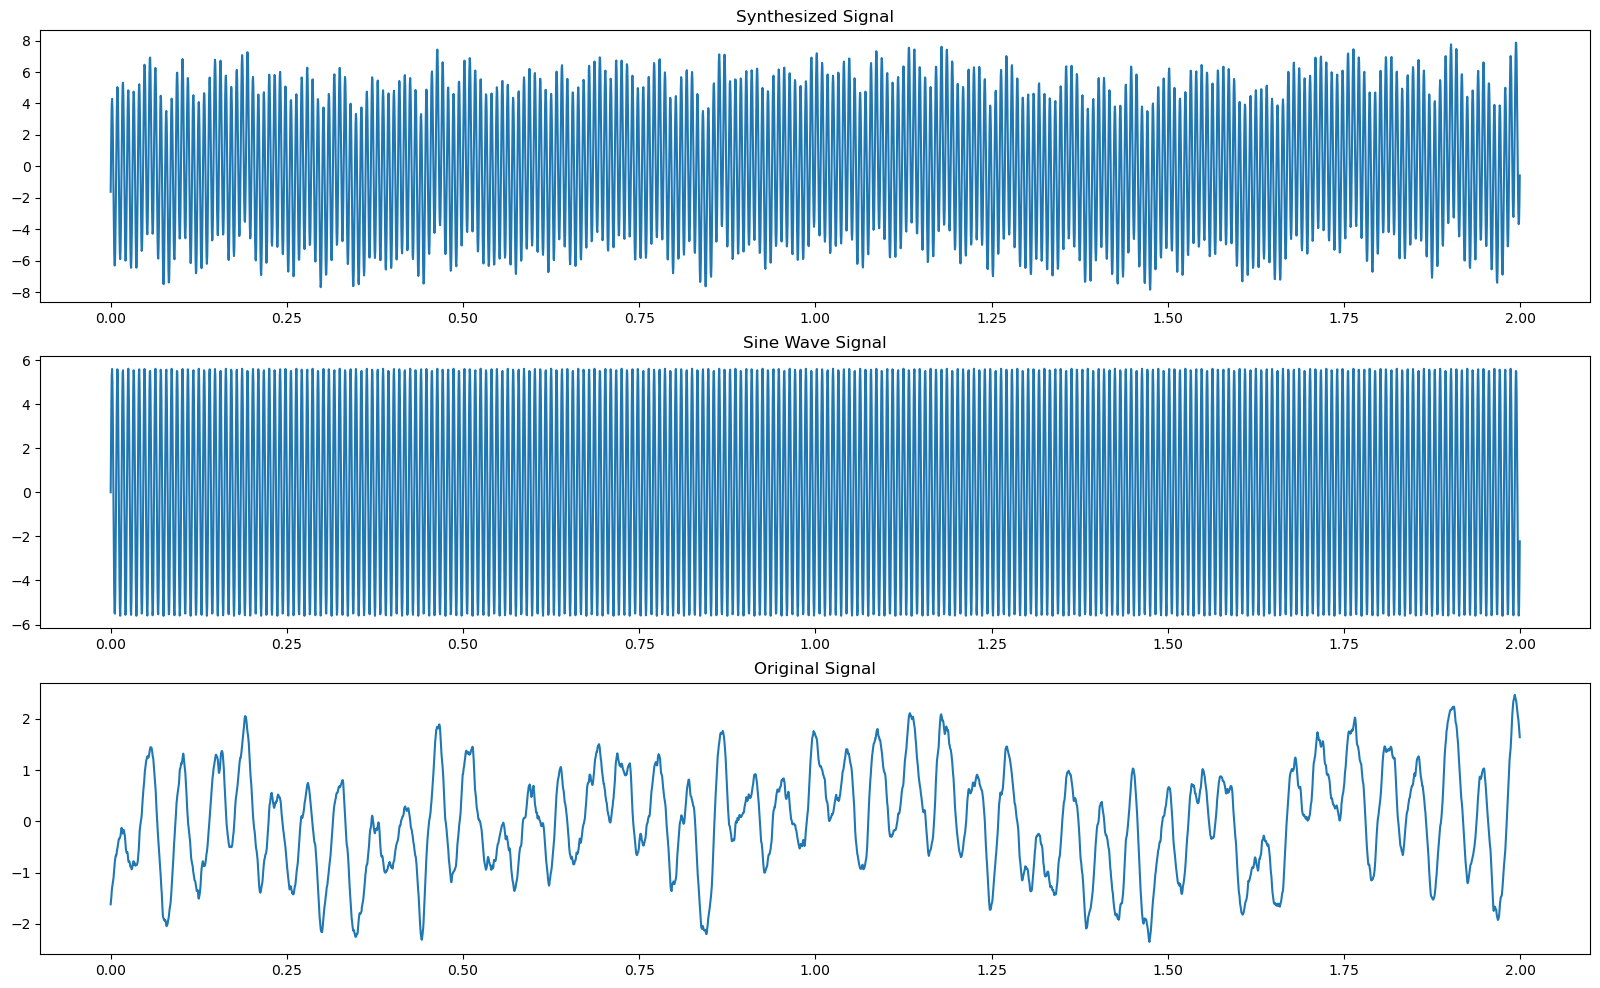

In [3]:
plt.figure(figsize=(20,12))
plt.subplot(3, 1, 1)
plt.plot(data1.iloc[:,0])
plt.title('Synthesized Signal')

plt.subplot(3, 1, 2)
plt.plot(data2.iloc[:,0])
plt.title('Sine Wave Signal')

plt.subplot(3, 1, 3)
plt.plot(data3.iloc[:,0])
plt.title('Original Signal')

In [4]:
# 정규화
scaler = MinMaxScaler()
df1 = scaler.fit_transform(data1).transpose()
df2 = scaler.fit_transform(data3).transpose()

df1.shape, df2.shape

((1000, 4000), (1000, 4000))

In [5]:
X = df1
y = df2

X.shape, y.shape

((1000, 4000), (1000, 4000))

In [6]:
# 훈련 세트와 검증 세트로 분할
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

#PyTorch Tensor로 변환
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32)

X_train.shape, y_train.shape

(torch.Size([800, 4000]), torch.Size([800, 4000]))

In [7]:
X_train = X_train.unsqueeze(1) # 배치수, 채널, Row
y_train = y_train.unsqueeze(1)

X_val = X_val.unsqueeze(1)
y_val = y_val.unsqueeze(1)

dataset = TensorDataset(X_train, y_train)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [8]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv1d(1, 16, 3, padding=1)  # Maintain length
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv1d(16, 1, 3, padding=1)  # Output layer to match input dimensions
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        return x

In [9]:
model = CNN()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

num_epochs = 100

for epoch in range(num_epochs):
    for i,(train_, label_) in enumerate(dataloader):        
        optimizer.zero_grad()
        y_pred = model(train_)
        loss = criterion(y_pred,label_)
        loss.backward()
        optimizer.step()
    if (epoch+1)%5 == 0:
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}')

Epoch 5/100, Loss: 0.03134293109178543
Epoch 10/100, Loss: 0.028108851984143257
Epoch 15/100, Loss: 0.025489460676908493
Epoch 20/100, Loss: 0.020850010216236115
Epoch 25/100, Loss: 0.016099432483315468
Epoch 30/100, Loss: 0.011599727906286716
Epoch 35/100, Loss: 0.005597285460680723
Epoch 40/100, Loss: 0.0034728790633380413
Epoch 45/100, Loss: 0.002636940684169531
Epoch 50/100, Loss: 0.0024403922725468874
Epoch 55/100, Loss: 0.0019632605835795403
Epoch 60/100, Loss: 0.0019574156031012535
Epoch 65/100, Loss: 0.0015275519108399749
Epoch 70/100, Loss: 0.001193223288282752
Epoch 75/100, Loss: 0.0011664185440167785
Epoch 80/100, Loss: 0.0010073991725221276
Epoch 85/100, Loss: 0.0011334458831697702
Epoch 90/100, Loss: 0.0017017513746395707
Epoch 95/100, Loss: 0.0015929760411381721
Epoch 100/100, Loss: 0.0011394997127354145


In [10]:
# 모델 평가
model.eval()
with torch.no_grad():
    val_outputs = model(X_val)
    val_loss = criterion(val_outputs, y_val)
    print(f'Validation Loss: {val_loss.item():.4f}')

Validation Loss: 0.0010


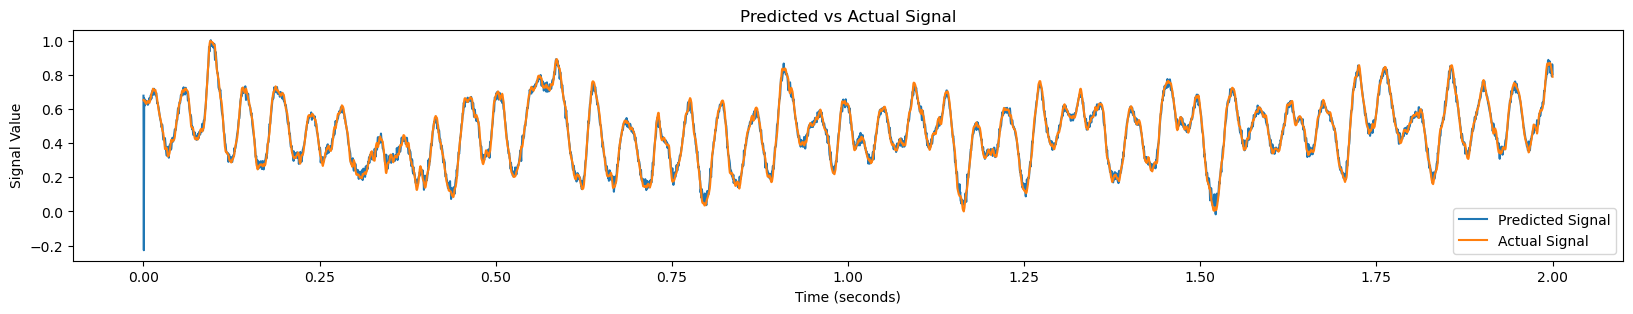

In [11]:
val_outputs1 = val_outputs.view(200, 4000).numpy()
y_val1 = y_val.view(200, 4000).numpy()

predicted_signal = val_outputs1[0].transpose()
actual_signal = y_val1[0].transpose()

# 타임 스텝을 시간 단위로 변환
time_steps = np.linspace(0, 2, num=4000)  

plt.figure(figsize=(20, 3))
plt.plot(time_steps, predicted_signal, label='Predicted Signal')
plt.plot(time_steps, actual_signal, label='Actual Signal')
plt.xlabel('Time (seconds)')
plt.ylabel('Signal Value')
plt.title('Predicted vs Actual Signal')
plt.legend()
plt.show()

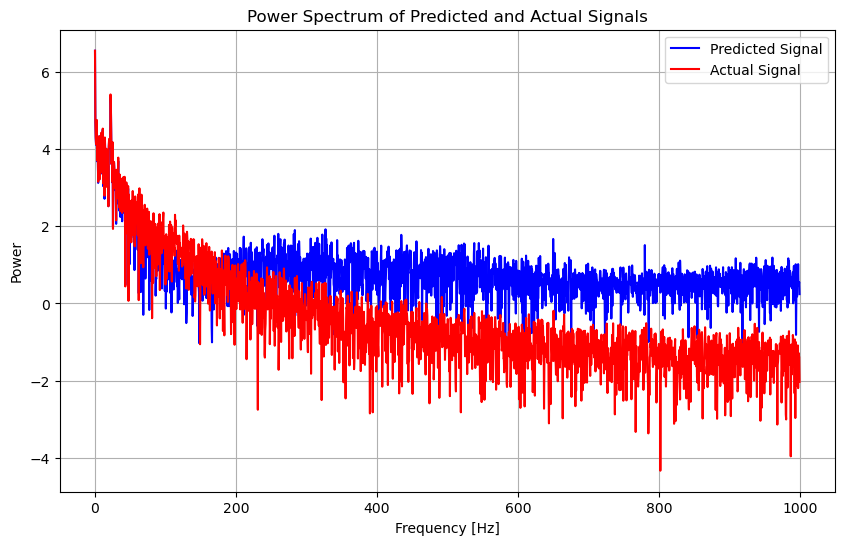

In [12]:
n = len(predicted_signal)

fs = 2000
freqs = np.fft.fftfreq(n, d=1/fs)[:n//2]

fft_predicted = np.fft.fft(predicted_signal)
fft_predicted = np.abs(fft_predicted[:n//2])
fft_predicted[1:] = 2 * fft_predicted[1:]
power_predicted = fft_predicted**2

fft_actual = np.fft.fft(actual_signal)
fft_actual = np.abs(fft_actual[:n//2])
fft_actual[1:] = 2 * fft_actual[1:]
power_actual = fft_actual**2

# 결과 플로팅
plt.figure(figsize=(10, 6))
plt.plot(freqs, np.log10(power_predicted), label='Predicted Signal', color='blue')
plt.plot(freqs, np.log10(power_actual), label='Actual Signal', color='red')
plt.title('Power Spectrum of Predicted and Actual Signals')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Power')
plt.legend()
plt.grid(True)
plt.show()